a) Introduction

The dataset I will be using for this project is the data collected from the Argo program headed by UCSD. The Argo program has been deploying and maintaining over 4,000 "floats" containing a wide array of sensors to measure 92 physical and chemical parameters in ocean waters since the early 2000s. These floats are deployed in the ocean and drift in its currents while taking measurements from the surface all the way down to 6000m of depth.

The primary variables of interest in this analysis are the ocean's temperature, salinity, pressure (used to measure depth), and the sensors' latitude and longitude coordinates. The response variable is going to be density, the driver of ocean circulation, which is a function of both salinity and temperature.
    
Insights about the flow of ocean currents from this analysis can be used to validate current oceanographic modeling techniques which are used heavy in weather, marine population, and marine transportation modeling.
    
The total size of the dataset is over 50gb, but I will only be working with the past 1 year of data in the Southern Ocean and retrieving specific parameters, resulting in a dataset size of ~240mb. All values have already been cleansed to ensure a high quality data set by the Argo program.

b) Problem Description

Problem:
Observing deep ocean current velocity derived from temperature and salinity transport.

The variables of interest are salinity (practical salinity units), temperature (degrees Celsius), pressure (decibars), latitude (decimal degrees), longitude (decimal degrees), and time. A density value will be derived from salinity and temperature and be used in combination with  geographic coordinates to determine the velocity of current flow.

c) Data Engineering Steps

Data comes from observation stations located in the Southern Ocean (-60 - -80 degrees latitude) from the pasy year (~56,000 observation cycles). Data will then be subsetted to isolate variables of interest (TIME, LATITUDE, LONGITUDE, PRES_ADJUSTED, TEMP_ADJUSTED, PSAL_ADJUSTED). Data will be subsetted to isolate data between 200m and 2000m of depth.


In [2]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import datetime
from seawater import dens
import time

Load all files into master dataframe

In [4]:
path = r"G:\My Drive\ArgoFloat\Data\1YearCSV"

all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


Drop Unnecessary Variables

In [5]:
to_drop = ['PLATFORM_CODE', 'DATE (YYYY-MM-DDTHH:MI:SSZ)','DATE_QC','POSITION_QC','PRES (decibar)','PRES_QC','TEMP_ADJUSTED_QC','PRES_ADJUSTED_QC','TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC']
tidydf = frame.drop(to_drop, axis = 1)
tidydf.head()

,LATITUDE (degree_north),LONGITUDE (degree_east),PRES_ADJUSTED (decibar),TEMP_ADJUSTED (degree_Celsius),PSAL_ADJUSTED (psu)
0,-60.0952,61.2471,4.89,0.3716,NaN
1,-60.0952,61.2471,6.63,0.3702,NaN
2,-60.0952,61.2471,8.58,0.3704,NaN
3,-60.0952,61.2471,10.58,0.3694,NaN
4,-60.0952,61.2471,12.62,0.3708,NaN


Drop na values

In [24]:
tidydf = tidydf.dropna(axis = 0)

Generate Response Variable

In [7]:
densArr = dens(tidydf["PSAL_ADJUSTED (psu)"], tidydf["TEMP_ADJUSTED (degree_Celsius)"], tidydf["PRES_ADJUSTED (decibar)"])
tidydf['Density'] = densArr.tolist()


Remove Data outside of 200-2000 decibars of pressure

In [9]:
tidydf = tidydf.loc[(tidydf["PRES_ADJUSTED (decibar)"] > 200) & (tidydf["PRES_ADJUSTED (decibar)"] < 2000)]

In [ ]:
tidydf.head()

In [12]:
#Split Data

from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split

s=tidydf.astype('int')

X=s.iloc[:,0:4]
y=s.iloc[:,5]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)



print(X.shape)
print(y.shape)



(2034525, 4)
(2034525,)


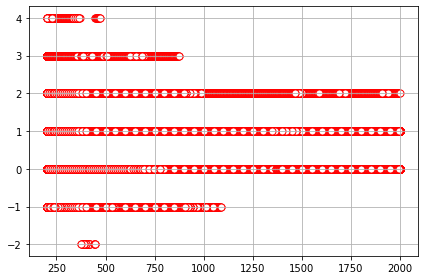

In [34]:
#K-Means Clustering
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans

plt.scatter(X["PRES_ADJUSTED (decibar)"], X["TEMP_ADJUSTED (degree_Celsius)"],
             color='white', marker='o', edgecolor='red', s=50)
plt.grid()
plt.tight_layout()
plt.show()

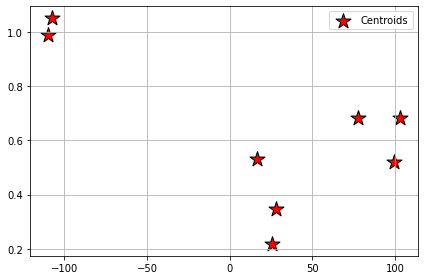

In [36]:
# Create an instance of K-Means
#
kmc = KMeans(n_clusters=8, init='random', n_init=10, max_iter=300,tol=1e-04, random_state=0)
#
# Fit and make predictions
#
y_kmc = kmc.fit_predict(X)
#
# Create the K-means cluster plot
#
plt.scatter(kmc.cluster_centers_[:, 1], kmc.cluster_centers_[:, 3],
            s=250, marker='*', c='red', edgecolor='black', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
#Decision Trees

# Creating Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
start_time = time.time()

clf = DecisionTreeClassifier()

param_grid = {
                 
                 'max_depth': [2, 3, 5, 7, 9]
             }

from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)


# performing predictions on the test dataset
y_pred = grid_clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()
print("--- %s seconds ---" % (time.time() - start_time))
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))



--- 3.7788748741149902 seconds ---
ACCURACY OF THE MODEL:  0.9680712788259959


accuracy:  0.9803144654088051
--- 2.4078166484832764 seconds ---
--- 145.89754724502563 seconds ---
[0.9219291878764432, 0.9194574312194066, 0.9227216533647571, 0.9211744362832501, 0.9237719822683401, 0.9223945947036427, 0.9234637996408652, 0.922941766097229, 0.9232185164242142, 0.9223820168784232, 0.9230990274801965, 0.9223757368660579, 0.9231304742188602, 0.9223317142800068, 0.9225329840086344, 0.9219795049130337, 0.9227090866153972, 0.9218034013173547, 0.9216902048460446, 0.9217468042683988, 0.9212813964522834, 0.9210235209722389, 0.9210801376017322, 0.9202876671688383, 0.9200109453226348, 0.9200172370042093, 0.9199732086824455, 0.9200738417667104, 0.9199166066889093, 0.9202247843718039]


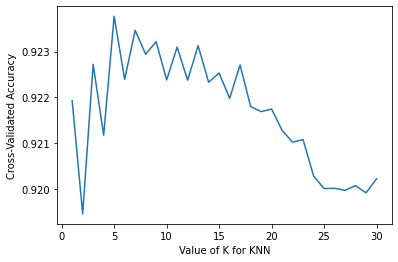

In [17]:
#knn

from sklearn import neighbors

# import k-folder
from sklearn.model_selection import cross_val_score
start_time = time.time()
# build KNN model and choose n_neighbors = 5
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
# train the model
knn.fit(X_train, y_train)
# get the predict value from X_test
y_pred = knn.predict(X_test)
# print the score
print('accuracy: ', knn.score(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))

# choose k between 1 to 31
k_range = range(1, 31)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    
print("--- %s seconds ---" % (time.time() - start_time))
# plot to see clearly
plt.plot(k_range, k_scores)
print(k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()


In [18]:
#Random Forests
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


#Cross Validation RF
param_grid = {
                 'n_estimators': [5, 10, 15, 20,30,50,70,100],
                 'max_depth': [2, 3, 5, 7, 9]
             }

from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = grid_clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

print("--- %s seconds ---" % (time.time() - start_time))



ACCURACY OF THE MODEL:  0.9829559748427673

ACCURACY OF THE MODEL:  0.9741719077568134
--- 459.0032615661621 seconds ---


In [19]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
start_time = time.time()


clf = LogisticRegression(random_state=0, solver='sag', max_iter = 10000).fit(X_train, y_train)
clf.predict(X_test)
print(clf.score(X_test, y_test))#mean accuracy score

print("--- %s seconds ---" % (time.time() - start_time))

0.889182389937107
--- 129.74147510528564 seconds ---


In [1]:
#Neural network - Sequential Model

import tensorflow as tf
from tensorflow import keras


In [22]:
model = keras.Sequential([keras.layers.Dense(32, input_shape=(4,), activation='relu'),
keras.layers.Dense((max(y_test) + 1), activation='relu'),
keras.layers.Dense((max(y_test) + 1), activation='sigmoid')])

model.compile(optimizer='adam', 
          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
          metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=4, epochs=1)

print("EVALUATION")
model.evaluate(X_test, y_test)

356042/356042 [==============================] - 1164s 3ms/step - loss: 0.3824 - accuracy: 0.8445
EVALUATION
19074/19074 [==============================] - 32s 2ms/step - loss: 0.2904 - accuracy: 0.8766


[0.2903934419155121, 0.8765904307365417]

In [23]:
#Linear Regression

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

start_time = time.time()

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

print("--- %s seconds ---" % (time.time() - start_time))

Coefficients: 
 [-6.11427090e-03  8.55812096e-05  4.68014789e-03 -7.34655525e-02]
Mean squared error: 0.09
Coefficient of determination: 0.98
--- 0.19745540618896484 seconds ---


| Model | Accuracy | Computation Time (seconds)|
| --- | --- | --- |
| Decision Tree | 0.968| 3.778 |
| KNN | 0.921 | 145.897 |
| Random Forests | 0.974 | 459.003 |
| Losgistic Regression | 0.889 | 129.741 |
| Neural Sequential Model | 0.8766 | 1164 |
| Linear Regression | Mean squared error: 0.09 | 0.197 |


Random Forests performed the best out of all models, with Decision Tree closely behind. I am surprised that the Sequential model performed the worst as its computation time and model complexity seems to be much higher than the other methods.

A theory for why tree based methods worked best is that they isolate variables and data ranges that dominate the response variable. Based on domain knowledge, only certain depth ranges result in high amount of varaiblility in the seawater desnity. Tree based algorithms may be able to isolate those ranges to determine the best tree for predicting the response variable compared to other models which may consider more noisy data.